In [62]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

In [63]:
import numpy as np
import pandas as pd
from matplotlib import style
import datetime
import pandas_datareader.data as web
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [93]:
import yfinance as yf
import csv

# Define the stock ticker and the date range
ticker = 'BBCA.JK'
train_start_date = '2010-01-04'
train_end_date = '2019-12-01'

test_start_date = '2020-01-02'
test_end_date = '2022-12-01'

validation_start_date = '2023-01-02'
validation_end_date = datetime.date.today()

# Get the data
train_data = yf.download(ticker, start=train_start_date, end=train_end_date)

train_data.to_csv('train_data.csv')


# Get the stock data using yahoo API:
# get 2009-2019 data to train our model
#train_data = web.DataReader('BBCA.JK', 'yahoo', datetime.datetime(2010,1,4),datetime.datetime(2019,12,1)) 

# get 2020 data to present date to test the SVM model
# test_data = web.DataReader('BBCA.JK', 'yahoo',  datetime.datetime(2020,1,2), datetime.date.today()) 
test_data = yf.download(ticker, start=test_start_date, end=test_end_date)
validation_data = yf.download(ticker, start=validation_start_date, end=validation_end_date)
#test_data = web.DataReader('BBCA.JK', 'yahoo',  datetime.datetime(2020,1,4), datetime.datetime(2021,12,1)) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1010.0,1010.0,965.0,1010.0,796.387817,77812500
2010-01-05,1020.0,1020.0,990.0,1020.0,804.272766,44442500
2010-01-06,990.0,1020.0,990.0,990.0,780.617615,27782500
2010-01-07,995.0,995.0,965.0,995.0,784.560242,38632500
2010-01-08,970.0,995.0,970.0,970.0,764.847595,27427500
...,...,...,...,...,...,...
2019-11-25,6330.0,6335.0,6275.0,6275.0,5610.080078,55133500
2019-11-26,6330.0,6330.0,6270.0,6285.0,5619.019043,192783500
2019-11-27,6270.0,6300.0,6240.0,6300.0,5632.430176,58833500


In [66]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,6695.0,6780.0,6680.0,6690.0,6000.031738,49445000
2020-01-03,6750.0,6800.0,6725.0,6800.0,6098.687500,47755500
2020-01-06,6720.0,6750.0,6690.0,6735.0,6040.391113,27300000
2020-01-07,6735.0,6770.0,6730.0,6740.0,6044.875488,45022500
2020-01-08,6670.0,6745.0,6670.0,6680.0,5991.063965,53692500
...,...,...,...,...,...,...
2022-11-24,8975.0,9000.0,8950.0,9000.0,8508.109375,53520800
2022-11-25,9000.0,9000.0,8900.0,8975.0,8484.474609,75048300
2022-11-28,9050.0,9100.0,8975.0,9025.0,8531.742188,96209700


In [67]:
# sort by date
train_data = train_data.sort_values('Date')
test_data = test_data.sort_values('Date')

# fix the date 
train_data.reset_index(inplace=True)
train_data.set_index("Date", inplace=True)
test_data.reset_index(inplace=True)
test_data.set_index("Date", inplace=True)

In [68]:
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1010.0,1010.0,965.0,1010.0,796.387817,77812500
2010-01-05,1020.0,1020.0,990.0,1020.0,804.272766,44442500
2010-01-06,990.0,1020.0,990.0,990.0,780.617615,27782500
2010-01-07,995.0,995.0,965.0,995.0,784.560242,38632500
2010-01-08,970.0,995.0,970.0,970.0,764.847595,27427500
...,...,...,...,...,...,...
2019-11-25,6330.0,6335.0,6275.0,6275.0,5610.080078,55133500
2019-11-26,6330.0,6330.0,6270.0,6285.0,5619.019043,192783500
2019-11-27,6270.0,6300.0,6240.0,6300.0,5632.430176,58833500


In [69]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,6695.0,6780.0,6680.0,6690.0,6000.031738,49445000
2020-01-03,6750.0,6800.0,6725.0,6800.0,6098.687500,47755500
2020-01-06,6720.0,6750.0,6690.0,6735.0,6040.391113,27300000
2020-01-07,6735.0,6770.0,6730.0,6740.0,6044.875488,45022500
2020-01-08,6670.0,6745.0,6670.0,6680.0,5991.063965,53692500
...,...,...,...,...,...,...
2022-11-24,8975.0,9000.0,8950.0,9000.0,8508.109375,53520800
2022-11-25,9000.0,9000.0,8900.0,8975.0,8484.474609,75048300
2022-11-28,9050.0,9100.0,8975.0,9025.0,8531.742188,96209700


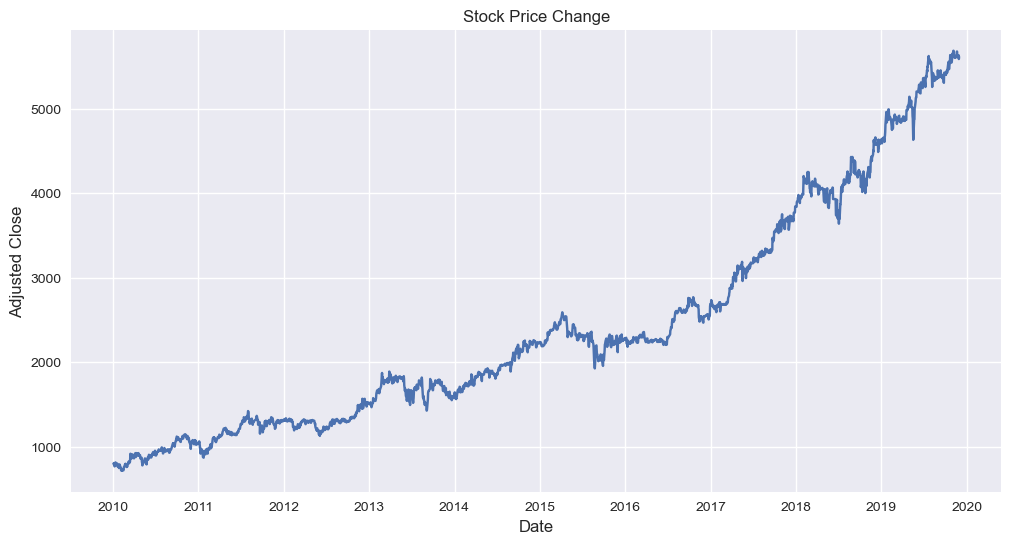

In [70]:
from matplotlib import pyplot as plt

style.use('seaborn')
plt.figure(figsize = (12,6))
plt.plot(train_data["Adj Close"])
plt.title("Stock Price Change")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Adjusted Close", fontsize = 12)
plt.show()

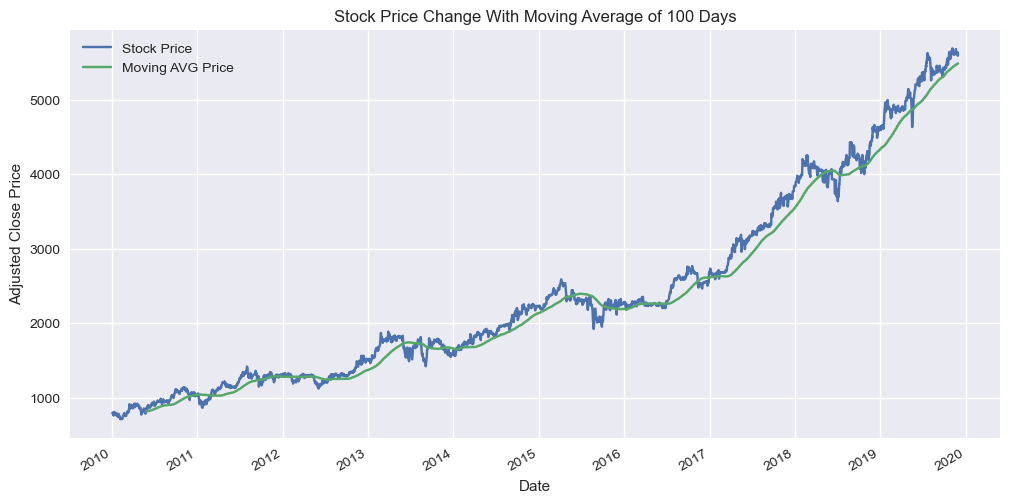

In [71]:
# Rolling mean
close_price = train_data['Adj Close']
moving_avg = close_price.rolling(window=100).mean()

plt.figure(figsize = (12,6))
plt.title("Stock Price Change With Moving Average of 100 Days")
close_price.plot(label='Stock Price')
moving_avg.plot(label='Moving AVG Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()

In [72]:
import matplotlib.dates as mdates

# change the dates into ints for training 
indxed_dates = train_data.copy()
indxed_dates = indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
actual_dates = indxed_dates['Date']

# convert to ints
indxed_dates['Date'] = indxed_dates['Date'].map(mdates.date2num)

indxed_dates

,Date,Open,High,Low,Close,Adj Close,Volume
0,14613.0,1010.0,1010.0,965.0,1010.0,796.387817,77812500
1,14614.0,1020.0,1020.0,990.0,1020.0,804.272766,44442500
2,14615.0,990.0,1020.0,990.0,990.0,780.617615,27782500
3,14616.0,995.0,995.0,965.0,995.0,784.560242,38632500
4,14617.0,970.0,995.0,970.0,970.0,764.847595,27427500
...,...,...,...,...,...,...,...
2466,18225.0,6330.0,6335.0,6275.0,6275.0,5610.080078,55133500
2467,18226.0,6330.0,6330.0,6270.0,6285.0,5619.019043,192783500
2468,18227.0,6270.0,6300.0,6240.0,6300.0,5632.430176,58833500
2469,18228.0,6295.0,6295.0,6245.0,6250.0,5587.728027,44248000


In [73]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates_data = indxed_dates['Date'].to_numpy()
prices_data = train_data['Adj Close'].to_numpy()

#Convert to 1d Vector
dates_data = np.reshape(dates_data, (len(dates_data), 1))
prices_data = np.reshape(prices_data, (len(prices_data), 1))

In [74]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1e4))
SVR_linear.fit(dates_data, prices_data)
SVR_linear_train = SVR_linear.predict(dates_data)

/Users/minseokim/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
SVR_linear_train

array([ 480.5019837 ,  481.51568339,  482.52938306, ..., 4144.01262051,
       4145.02632019, 4146.04001986])

In [76]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e4, gamma= 0.01)
SVR_rbfk.fit(dates_data, prices_data)
SVR_rbfk_train = SVR_rbfk.predict(dates_data)

/Users/minseokim/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
SVR_rbfk_train

array([ 797.14289095,  786.4072945 ,  780.71779447, ..., 5609.01426878,
       5590.9003445 , 5559.4423861 ])

In [78]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=3, epsilon=0.1, coef0=1))
SVR_poly.fit(dates_data, prices_data)
SVR_poly_train = SVR_poly.predict(dates_data)

/Users/minseokim/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
SVR_poly_train

array([ 730.99269641,  732.10922504,  733.22462882, ..., 5766.06077037,
       5770.04207329, 5774.02608747])

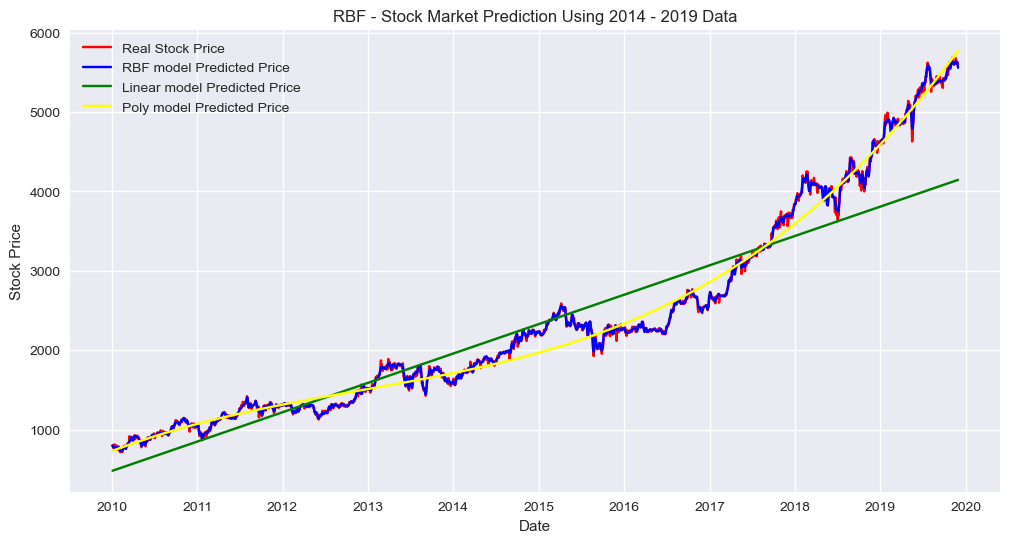

In [80]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2014 - 2019 Data')
plt.plot(dates_data, prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(actual_dates, SVR_rbfk_train, color= 'blue', label= 'RBF model Predicted Price') 
plt.plot(actual_dates, SVR_linear_train, color= 'green', label= 'Linear model Predicted Price') 
plt.plot(actual_dates, SVR_poly_train, color= 'yellow', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [81]:
# change the dates into ints for training 
test_indxed_dates = test_data.copy()
test_indxed_dates = test_indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
test_actual_dates = test_indxed_dates['Date']

# convert to ints
test_indxed_dates['Date'] = test_indxed_dates['Date'].map(mdates.date2num)

In [82]:
test_indxed_dates

,Date,Open,High,Low,Close,Adj Close,Volume
0,18263.0,6695.0,6780.0,6680.0,6690.0,6000.031738,49445000
1,18264.0,6750.0,6800.0,6725.0,6800.0,6098.687500,47755500
2,18267.0,6720.0,6750.0,6690.0,6735.0,6040.391113,27300000
3,18268.0,6735.0,6770.0,6730.0,6740.0,6044.875488,45022500
4,18269.0,6670.0,6745.0,6670.0,6680.0,5991.063965,53692500
...,...,...,...,...,...,...,...
708,19320.0,8975.0,9000.0,8950.0,9000.0,8508.109375,53520800
709,19321.0,9000.0,9000.0,8900.0,8975.0,8484.474609,75048300
710,19324.0,9050.0,9100.0,8975.0,9025.0,8531.742188,96209700
711,19325.0,8975.0,9075.0,8925.0,8975.0,8484.474609,91562100


In [83]:
test_dates_data = test_indxed_dates['Date'].to_numpy()
test_prices_data = test_data['Adj Close'].to_numpy()

#Convert to 1d Vector
test_dates_data = np.reshape(test_dates_data, (len(test_dates_data), 1))
test_prices_data = np.reshape(test_prices_data, (len(test_prices_data), 1))

In [84]:
# SVR_rbfk = SVR(kernel= 'rbf', C= 1e4, gamma= 0.01)
# SVR_rbfk.fit(test_dates_data, test_prices_data)
SVR_rbfk_test = SVR_rbfk.predict(test_dates_data)
SVR_rbfk_test

array([2407.42549335, 2407.39492227, 2407.36713963, 2407.36521419,
       2407.36429924, 2407.3638735 , 2407.3636795 , 2407.36353888,
       2407.36353209, 2407.3635293 , 2407.36352817, 2407.36352773,
       2407.36352747, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352746,
       2407.36352746, 2407.36352746, 2407.36352746, 2407.36352

In [85]:
# SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1))
# SVR_linear.fit(test_dates_data, test_prices_data)
SVR_linear_test =  SVR_linear.predict(test_dates_data)
SVR_linear_test

array([4180.50580893, 4181.51950857, 4184.56060764, 4185.57430733,
       4186.58800698, 4187.60170668, 4188.61540638, 4191.6565054 ,
       4192.67020506, 4193.68390475, 4194.69760441, 4195.7113041 ,
       4198.75240312, 4199.76610282, 4200.77980248, 4201.79350215,
       4202.80720185, 4205.84830088, 4206.86200057, 4207.87570025,
       4208.88939992, 4209.90309959, 4212.94419862, 4213.9578983 ,
       4214.97159799, 4215.98529767, 4216.99899734, 4220.04009637,
       4221.05379604, 4222.06749574, 4223.08119539, 4224.09489507,
       4227.13599412, 4228.1496938 , 4229.16339348, 4230.17709317,
       4231.19079283, 4234.23189188, 4235.24559154, 4236.25929122,
       4237.27299091, 4238.28669058, 4241.32778962, 4242.3414893 ,
       4243.35518898, 4244.36888867, 4245.38258832, 4248.42368737,
       4249.43738703, 4250.45108673, 4251.46478642, 4252.47848608,
       4255.51958513, 4256.53328479, 4257.54698448, 4258.56068412,
       4259.57438383, 4262.61548285, 4263.62918254, 4265.65658

In [86]:
# SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=4, epsilon=0.1, coef0=1))
# SVR_poly.fit(test_dates_data, test_prices_data)
SVR_poly_test = SVR_poly.predict(test_dates_data)
SVR_poly_test

array([ 5911.10335551,  5915.18293294,  5927.43816638,  5931.52874812,
        5935.62208358,  5939.71817385,  5943.81701996,  5956.13010403,
        5960.23998417,  5964.35262547,  5968.46802899,  5972.5861958 ,
        5984.95728654,  5989.08651709,  5993.21851623,  5997.35328503,
        6001.49082454,  6013.92007798,  6018.06871096,  6022.22011996,
        6026.37430605,  6030.53127027,  6043.01884244,  6047.18692986,
        6051.35780074,  6055.53145612,  6059.70789708,  6072.25394401,
        6076.44153788,  6080.63192263,  6084.82509933,  6089.02106902,
        6101.62574676,  6105.83289908,  6110.04284973,  6114.25559975,
        6118.47115019,  6131.13461476,  6135.36137756,  6139.59094611,
        6143.82332146,  6148.05850467,  6160.78091211,  6165.0273374 ,
        6169.27657585,  6173.52862854,  6177.78349653,  6190.56500288,
        6194.83114265,  6199.10010304,  6203.37188508,  6207.64648986,
        6220.48725114,  6224.77315742,  6229.06189175,  6233.35345516,
      

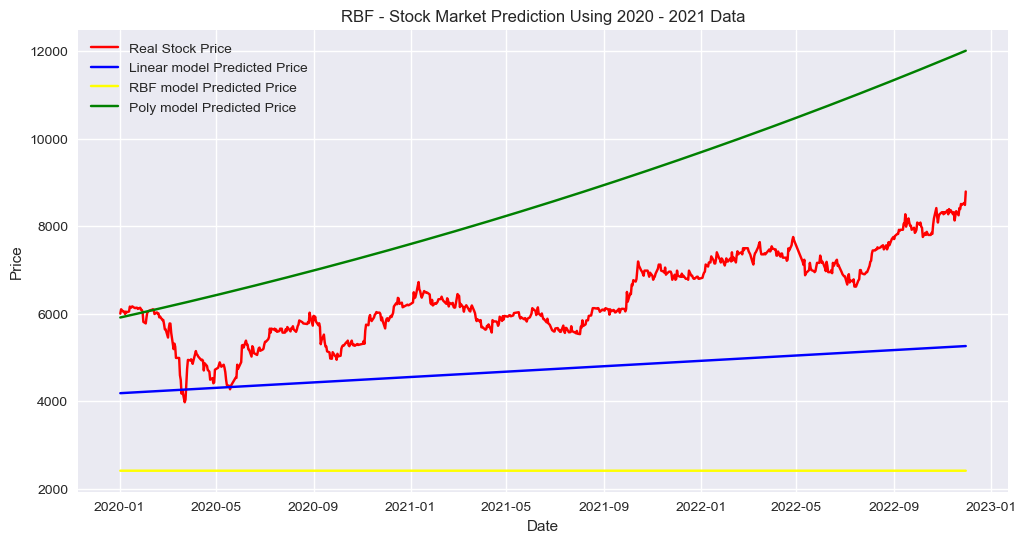

In [87]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2020 - 2021 Data')
plt.plot(test_dates_data, test_prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(test_actual_dates, SVR_linear_test, color= 'blue', label= 'Linear model Predicted Price')
plt.plot(test_actual_dates, SVR_rbfk_test, color= 'yellow', label= 'RBF model Predicted Price')
plt.plot(test_actual_dates, SVR_poly_test, color= 'green', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [88]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("SVR RBF Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_rbfk_train)))

print("SVR RBF Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_rbfk_train))

print("SVR RBF Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_rbfk_train))

print("SVR RBF Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_rbfk_test)))

print("SVR RBF Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_rbfk_test))

print("SVR RBF Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_rbfk_test))


SVR RBF Train RMSE: 23.58
SVR RBF Train R2 Score: 1.00
SVR RBF Train MAE Score: 13.65
SVR RBF Test RMSE: 4065.61
SVR RBF Test R2 Score: -17.19
SVR RBF Test MAE Score: 3952.28


In [89]:
print("SVR Linear Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_linear_train)))

print("SVR Linear Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_linear_train))

print("SVR Linear Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_linear_train))

print("SVR Linear Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_linear_test)))

print("SVR Linear Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_linear_test))

print("SVR Linear Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_linear_test))

SVR Linear Train RMSE: 483.91
SVR Linear Train R2 Score: 0.86
SVR Linear Train MAE Score: 350.79
SVR Linear Test RMSE: 1780.41
SVR Linear Test R2 Score: -2.49
SVR Linear Test MAE Score: 1639.78


In [90]:
print("SVR Poly Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_poly_train)))

print("SVR Poly Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_poly_train))

print("SVR Poly Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_poly_train))

print("SVR Poly Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_poly_test)))

print("SVR Poly Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_poly_test))

print("SVR Poly Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_poly_test))

SVR Poly Train RMSE: 160.79
SVR Poly Train R2 Score: 0.99
SVR Poly Train MAE Score: 121.65
SVR Poly Test RMSE: 2527.13
SVR Poly Test R2 Score: -6.03
SVR Poly Test MAE Score: 2313.16


Validation Results:
Mean Squared Error: 46781574.18969094
R-squared: -81.78964921276035


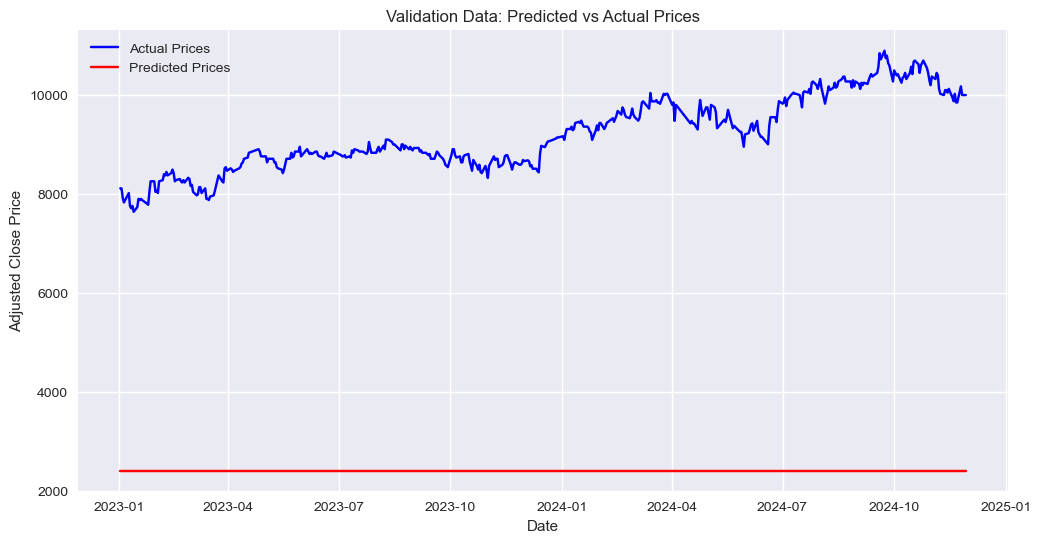

In [94]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, r2_score

# Process validation data
validation_indxed_dates = validation_data.copy()
validation_indxed_dates = validation_indxed_dates.reset_index()

# Store original dates for plotting
validation_actual_dates = validation_indxed_dates['Date']

# Convert dates to numerical format
validation_indxed_dates['Date'] = validation_indxed_dates['Date'].map(mdates.date2num)

# Prepare validation data
validation_dates_data = validation_indxed_dates['Date'].to_numpy()
validation_prices_data = validation_indxed_dates['Adj Close'].to_numpy()

# Convert to 1D vector
validation_dates_data = np.reshape(validation_dates_data, (len(validation_dates_data), 1))
validation_prices_data = np.reshape(validation_prices_data, (len(validation_prices_data), 1)).ravel()

# Predict using the trained SVR model
SVR_rbfk_validation = SVR_rbfk.predict(validation_dates_data)

# Evaluate performance
validation_mse = mean_squared_error(validation_prices_data, SVR_rbfk_validation)
validation_r2 = r2_score(validation_prices_data, SVR_rbfk_validation)

print("Validation Results:")
print(f"Mean Squared Error: {validation_mse}")
print(f"R-squared: {validation_r2}")

# Plot validation results
plt.figure(figsize=(12, 6))
plt.title("Validation Data: Predicted vs Actual Prices")
plt.plot(validation_actual_dates, validation_prices_data, label='Actual Prices', color='blue')
plt.plot(validation_actual_dates, SVR_rbfk_validation, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()